In [2]:
#!pip install -U statsmodels

In [3]:
#!pip install pmdarima

In [69]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import pmdarima as pm

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


# Análise Exploratória

## Lendo e plotando dataframe

In [5]:
df = pd.read_excel("morte_armas_australia.xlsx")

In [6]:
df.set_index('Year', inplace=True)

<AxesSubplot:xlabel='Year'>

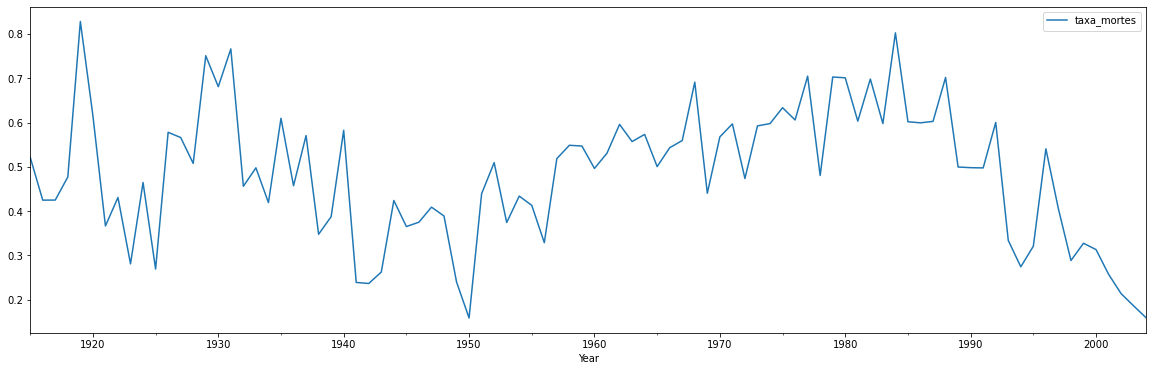

In [7]:
df[['taxa_mortes']].plot(figsize=(20,6))

## Decomposição da séries: tendência, sazonalidade, resíduo

### Periodo de 1 ano

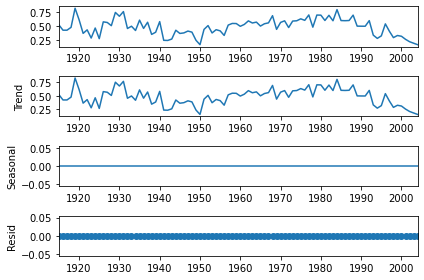

In [8]:
df_decomp = tsa.seasonal_decompose(df, period = 1)
df_decomp.plot();

### Periodo 5 anos

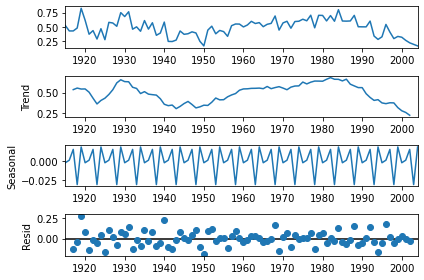

In [9]:
df_decomp = tsa.seasonal_decompose(df, period = 5)
df_decomp.plot();

### Periodo de 10 anos

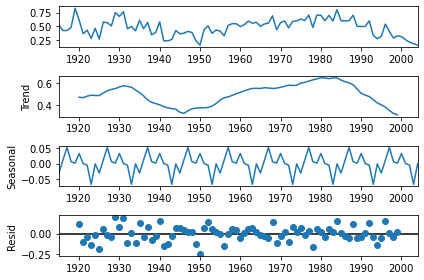

In [10]:
df_decomp = tsa.seasonal_decompose(df, period = 10)
df_decomp.plot();

### Periodo de 15 anos

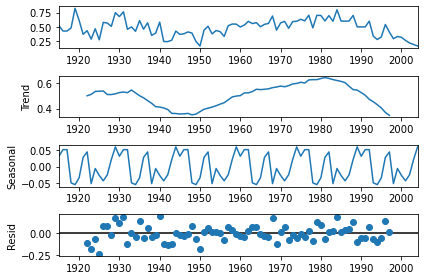

In [11]:
df_decomp = tsa.seasonal_decompose(df, period = 15)
df_decomp.plot();

Observa que a série apresenta um sazonalidade bem definida para periodos maiores que 1 ano e tendência apróximadamente senoidal que fica clara com o aumento do período estudado

## Estacionaridade

Estacionariedade: média e desvio constante ao longo do tempo

Média móvel de 2, 5 e 10 anos

<AxesSubplot:xlabel='Year'>

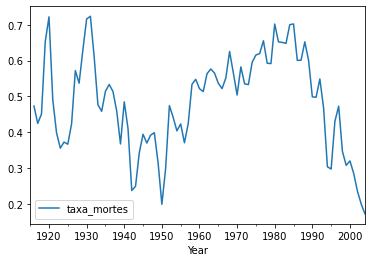

In [12]:
df.rolling(2).mean().plot()

<AxesSubplot:xlabel='Year'>

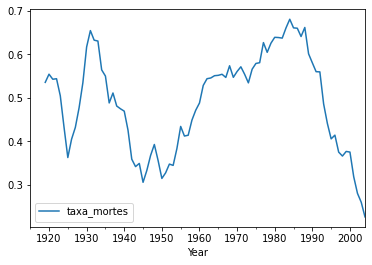

In [13]:
df.rolling(5).mean().plot()

<AxesSubplot:xlabel='Year'>

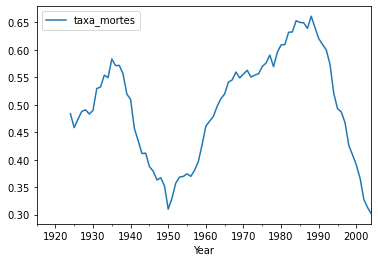

In [14]:
df.rolling(10).mean().plot()

Média movel possui uma tendencia e sazonalidade evidenciando que a série não é estacionária pois as características estatísticas não se mantem constante com o tempo

<AxesSubplot:ylabel='Frequency'>

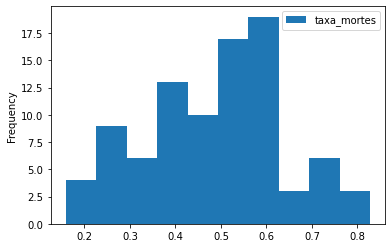

In [15]:
df.plot.hist()

Apresenta uma distribuição não simétrica dos dados

## Diferenciação

Utiliza a diferenciação para tentar tornar a série estacionária devido ao fato dos modelos existentes terem como premissa uma série estacionária.

In [16]:
dfd1 = df.diff().dropna()

<AxesSubplot:xlabel='Year'>

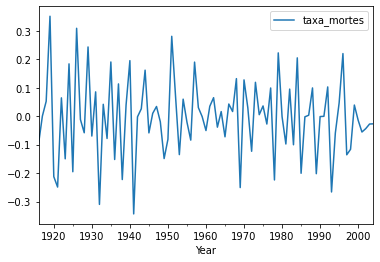

In [17]:
dfd1.plot()

A série agora aprotenta modulos do máximo e mínimo aproximadamente iguais e aparentemente sem tendencias, podendo ainda haver alguma sazonalidade

<AxesSubplot:ylabel='Frequency'>

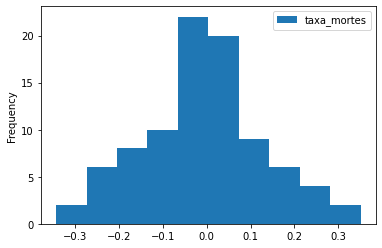

In [18]:
dfd1.plot.hist()

Apresenta uma distribuição aproximadamente normal, indicando uma estacionaridade

In [19]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1, regression='ct')
print(pvalue)
print(lags)

1.7133988986591557e-12
2


O teste Dickey-Fuller (ADF) rejeita a hipótese nula de não estacionaridade usando 2 lags, o p-valor foi inferior 5%, portanto há evidência estatística de que a série diferenciada é estacionária. (VERIFICAR SE ISSO TA CERTO)

## Autocorrelação

A correlação de uma variável consigo mesma em momentos diferentes

#### Série com lag (atraso) = 1

In [20]:
df.shift(1).head()

,taxa_mortes
Year,
1915-01-01,NaN
1916-01-01,0.521505
1917-01-01,0.424828
1918-01-01,0.425031
1919-01-01,0.477194


In [21]:
df.corrwith(df.shift(1))

taxa_mortes    0.576197
dtype: float64

Apresentou uma autocorrelação baixa

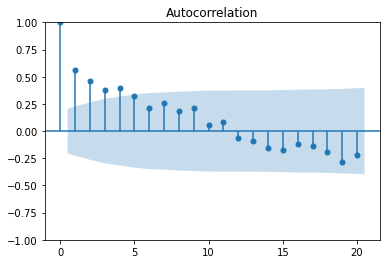

In [22]:
plot_acf(df);

O gráfico da autocorrelção deve ser feito para poder identificar qual o melhor modelo a ser usado, não deve ser usado esse gráfico pois a série não é estacionária, então é necessário fazer a autocorrelação na série diferenciada que apresenta características estacionárias.

#### Autocorrelação para série diferenciada

In [23]:
dfd1.corrwith(dfd1.shift(1))

taxa_mortes   -0.406713
dtype: float64

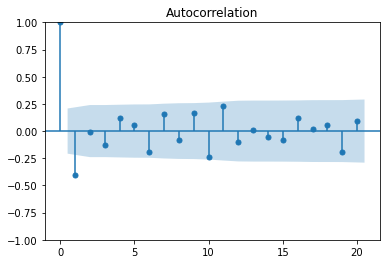

In [24]:
plot_acf(dfd1);

Os legs representativos são os que estão fora da faixa azul do gráfico, pois a faixa azul representa o grau de significância da correlação. Neste caso deve ser usado os legs 1 e 2

### Autocorrelação Parcial

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


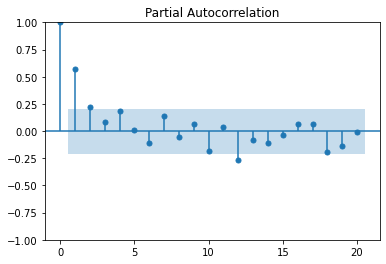

In [25]:
plot_pacf(df);

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


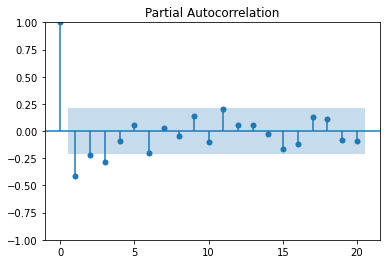

In [26]:
plot_pacf(dfd1);

A autocorrelação parcial mostra que poucos lags apresentação correlação com significância estatística

# AR model (p)

### Separando em treino, teste e validação seguindo a ordem temporal

In [27]:
df_train = df.iloc[:int(len(df) * 0.5)]
df_test = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
df_valid = df.iloc[int(len(df) * 0.75):]

In [32]:
print(len(df_train),len(df_test),len(df_valid))

45 22 23


### Definição e treino do modelo

O melhor número de legs a ser usado é 2 de acordo com o que foi visto no gráfico de autocorrelação.

#### Aplicando o modelo para duas legs  na série diferenciada 

In [56]:
df_model =  ARIMA(df_train, order=(2,0,0))
res = df_model.fit()
res.summary()

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            taxa_mortes   No. Observations:                   45
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  27.661
Date:                Thu, 14 Apr 2022   AIC                            -47.322
Time:                        13:22:41   BIC                            -40.096
Sample:                    01-01-1915   HQIC                           -44.628
                         - 01-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4584      0.036     12.639      0.000       0.387       0.530
ar.L1          0.3500      0.162      2.155      0.031       0.032       0.668
ar.L2          0.0986      0.160      0.616      0.538      -0.215       0.412
sigma2         0.0171      0.004      4.632      0.000       0.010       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.95   Prob(JB):                         0.60
Heteroskedasticity (H):               0.44   Skew:                             0.37
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

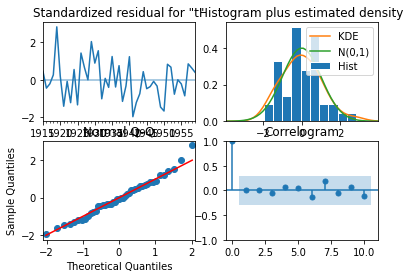

In [57]:
res.plot_diagnostics();

Analisando os gráficos do resido é possível perceber que ele se aprossima da normal, indicando que não há tendencias nem sazonalidade, a maioria dos postos quantitativos apresentam em cima da reta, indicando a não existencia de viés e não há lags com grandes correlações.

In [58]:
res2 = res.apply(df_test)

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [59]:
res2.predict()

1960-01-01    0.458433
1961-01-01    0.473156
1962-01-01    0.487533
1963-01-01    0.513649
1964-01-01    0.506498
1965-01-01    0.508305
1966-01-01    0.484484
1967-01-01    0.492229
1968-01-01    0.502112
1969-01-01    0.549844
1970-01-01    0.475059
1971-01-01    0.494880
1972-01-01    0.517673
1973-01-01    0.477383
1974-01-01    0.506810
1975-01-01    0.520338
1976-01-01    0.533397
1977-01-01    0.527238
1978-01-01    0.559120
1979-01-01    0.490446
1980-01-01    0.546099
1981-01-01    0.567386
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [60]:
pd.concat([res2.predict(),df_test],axis=1)

,predicted_mean,taxa_mortes
1960-01-01,0.458433,0.496349
1961-01-01,0.473156,0.530893
1962-01-01,0.487533,0.595776
1963-01-01,0.513649,0.557058
1964-01-01,0.506498,0.573133
1965-01-01,0.508305,0.500542
1966-01-01,0.484484,0.543127
1967-01-01,0.492229,0.559366
1968-01-01,0.502112,0.691169
1969-01-01,0.549844,0.440348


#### Plotando a previsão do modelo para um step a frente

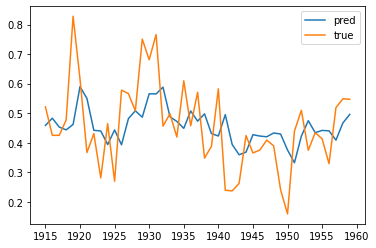

In [61]:
fig, ax = plt.subplots()
ax.plot(res.predict(), label='pred')
ax.plot(df_train, label='true')
plt.legend()

O gráfico sugere que o o modelo AR não se hadaptou de mareira positiva aos dados reais, não conseguindo acompanhar a série original. 

#### Verificando as Métricas

Análise das métricas de erro do modelo

R2: mais próximo de 1 é melhor

MSE: mais próximo de 0 é melhor

MAE: mais próximo de 0 é melhor

MAPE: mais próximo de 0 é melhor

In [71]:
print('Resultados do Modelo AR - 2 legs\n')
print('R2' ,r2_score(res2.predict(), df_test))
print('MSE' ,mean_squared_error(res2.predict(), df_test))
print('MAE', mean_absolute_error(res2.predict(), df_test))
print('MAPE', mean_absolute_percentage_error(res2.predict(), df_test))

Resultados do Modelo AR - 2 legs

R2 -12.672925065845003
MSE 0.011221970972559451
MAE 0.09248399962047425
MAPE 0.18211432767031488


A métrica R2_score apresenta um valor muito longe de 1 confirmando a observação visual do gráfico que o modelo não se adequa bem a esta série.

#### Previsão da série para o conjunto de teste com multi step recursivo

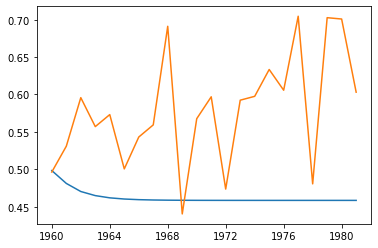

In [67]:
fig, ax = plt.subplots()
ax.plot(pd.concat([res.forecast(int(len(df)*0.25)), df_test],axis=1))

O modelo não consegue se ajustar se não tiver os dados anuais da série, ou seja, quando aumenta o número de steps o modelo piora o seu desempenho. 

#### Seleção da melhor ordem para o modelo AR

In [81]:
from statsmodels.tsa.stattools import arma_order_select_ic
ar_order_selection = arma_order_select_ic(dfd1, max_ar=10, max_ma=0)
ar_order_selection

{'bic':              0
 0   -90.980146
 1  -102.404223
 2  -101.931170
 3  -104.108831
 4  -100.169603
 5   -95.994068
 6   -94.823044
 7   -90.346407
 8   -86.151204
 9   -83.245324
 10  -79.469508,
 'bic_min_order': (3, 0)}

# MA model (q)

#### Seleção da melhor ordem para o modelo MA

In [80]:
from statsmodels.tsa.stattools import arma_order_select_ic
ar_order_selection = arma_order_select_ic(dfd1, max_ar=0, max_ma=10)
ar_order_selection

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

{'bic':           0           1           2           3           4          5   \
 0 -90.980146 -111.806545 -107.615207 -103.137037 -100.773169 -96.305349   
 
           6          7          8         9          10  
 0 -91.883873 -80.695035 -85.978684 -82.44703 -79.194306  ,
 'bic_min_order': (0, 1)}

melhor ordem é de 2 legs

#### Aplicando o modelo para duas legs 

In [73]:
df_model =  ARIMA(df_train, order=(0,0,2))
res = df_model.fit()
res.summary()

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            taxa_mortes   No. Observations:                   45
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  27.650
Date:                Thu, 14 Apr 2022   AIC                            -47.301
Time:                        14:07:10   BIC                            -40.074
Sample:                    01-01-1915   HQIC                           -44.607
                         - 01-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4573      0.032     14.266      0.000       0.394       0.520
ma.L1          0.3703      0.154      2.411      0.016       0.069       0.671
ma.L2          0.2206      0.155      1.424      0.154      -0.083       0.524
sigma2         0.0171      0.004      4.761      0.000       0.010       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.99   Prob(JB):                         0.62
Heteroskedasticity (H):               0.48   Skew:                             0.35
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

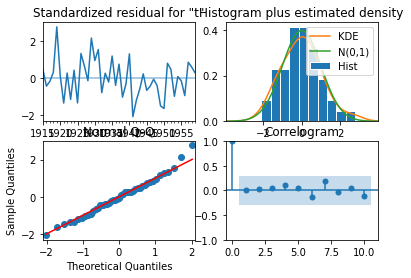

In [74]:
res.plot_diagnostics();

In [75]:
res2 = res.apply(df_test)
res2.predict()

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


1960-01-01    0.457318
1961-01-01    0.472195
1962-01-01    0.485886
1963-01-01    0.510509
1964-01-01    0.498537
1965-01-01    0.495188
1966-01-01    0.475752
1967-01-01    0.483447
1968-01-01    0.500293
1969-01-01    0.544745
1970-01-01    0.460770
1971-01-01    0.473869
1972-01-01    0.526460
1973-01-01    0.464871
1974-01-01    0.492866
1975-01-01    0.524215
1976-01-01    0.520847
1977-01-01    0.512831
1978-01-01    0.547052
1979-01-01    0.474992
1980-01-01    0.526953
1981-01-01    0.571959
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [76]:
pd.concat([res2.predict(),df_test],axis=1)

,predicted_mean,taxa_mortes
1960-01-01,0.457318,0.496349
1961-01-01,0.472195,0.530893
1962-01-01,0.485886,0.595776
1963-01-01,0.510509,0.557058
1964-01-01,0.498537,0.573133
1965-01-01,0.495188,0.500542
1966-01-01,0.475752,0.543127
1967-01-01,0.483447,0.559366
1968-01-01,0.500293,0.691169
1969-01-01,0.544745,0.440348


#### Plotando a previsão do modelo para um step a frente

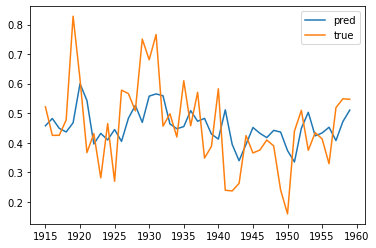

In [77]:
fig, ax = plt.subplots()
ax.plot(res.predict(), label='pred')
ax.plot(df_train, label='true')
plt.legend()

#### Verificando as Métricas

In [78]:
print('Resultados do Modelo AR - 2 legs\n')
print('R2' ,r2_score(res2.predict(), df_test))
print('MSE' ,mean_squared_error(res2.predict(), df_test))
print('MAE', mean_absolute_error(res2.predict(), df_test))
print('MAPE', mean_absolute_percentage_error(res2.predict(), df_test))

Resultados do Modelo AR - 2 legs

R2 -13.185867354591455
MSE 0.012837732040640742
MAE 0.0987671986014431
MAPE 0.1985837669651174


#### Previsão da série para o conjunto de teste com multi step recursivo

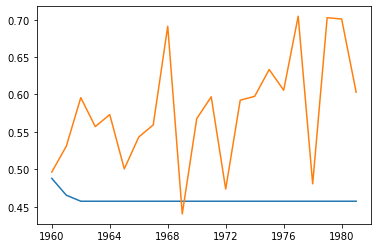

In [79]:
fig, ax = plt.subplots()
ax.plot(pd.concat([res.forecast(int(len(df)*0.25)), df_test],axis=1))

# AUTO ARIMA model (p,d,q)

Auto arima (p, d, q)
Modelo ARIMA

p = AR
d = diferenciação
q = MA
Auto arima faz uma busca em grade pela melhor ordem para o modelo:

p = [0, 10]
d = [0, 2]
q = [0, 5]